In [1]:
import zipfile
import os

# Define paths
zip_path = '/content/archive (13).zip'
unzip_dir = '/content/dataset_lung_health_images'

# Ensure the unzip directory exists
os.makedirs(unzip_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Extract the ZIP file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print("Extraction completed successfully.")
except zipfile.BadZipFile:
    print("Error: The file is not a zip file or it is corrupted.")
except FileNotFoundError:
    print(f"Error: The file {zip_path} was not found.")
except PermissionError:
    print("Error: Permission denied while accessing files.")
except Exception as e:
    print(f"An unexpected error occurred during extraction: {e}")

# List all files in the extracted directory
try:
    for root, dirs, files in os.walk(unzip_dir):
        print(f"Directory: {root}")
        for name in files:
            file_path = os.path.join(root, name)
            try:
                # Attempt to print file details
                print(f"File: {file_path}")
            except Exception as e:
                print(f"An error occurred while processing file {file_path}: {e}")
except Exception as e:
    print(f"An error occurred while listing files: {e}")

Extraction completed successfully.
Directory: /content/dataset_lung_health_images
Directory: /content/dataset_lung_health_images/Data
Directory: /content/dataset_lung_health_images/Data/test
Directory: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000141.png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000155.png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000108.png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000172 (2).png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000147 (2).png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000159.png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000174.png
File: /content/dataset_lung_health_images/Data/test/large.cell.carcinoma/000163.png
File: /content/dataset_lung_health_images/Data/test

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Dense ,Conv2D,MaxPooling2D,Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming your images are in subdirectories named 'train', 'valid', and 'test'
train_data_dir = '/content/dataset_lung_health_images/Data/train'
valid_data_dir = '/content/dataset_lung_health_images/Data/valid'
test_data_dir = '/content/dataset_lung_health_images/Data/test'

# Create data generators for training, validation, and testing with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,        # Randomly rotate images by 40 degrees
    width_shift_range=0.2,    # Shift images horizontally by 20%
    height_shift_range=0.2,   # Shift images vertically by 20%
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom into images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill missing pixels after transformation
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and process image data for training
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(200, 200),   # Increase the target size to capture more details
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    color_mode='grayscale'     # Load images as grayscale
)

# Load and process image data for validation
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'     # Load images as grayscale
)

# Load and process image data for testing
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'     # Load images as grayscale
)

# Access data and labels for testing purposes
X_train, Y_train = train_generator.__next__()
X_valid, Y_valid = valid_generator.__next__()
X_test, Y_test = test_generator.__next__()

print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_valid: ", X_valid.shape)
print("Shape of Y_valid: ", Y_valid.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

# Define the CNN model
model = models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),  # grayscale input
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output
    layers.Flatten(),

    # Dense Layer 1 - 1024 units
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

    # # Dropout to reduce overfitting
    # layers.Dropout(0.5),

    # Dense Layer 2 - 512 units
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

    # # Dropout to reduce overfitting
    # layers.Dropout(0.5),

    # Dense Layer 3 - 256 units
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

    # # Dropout to reduce overfitting
    # layers.Dropout(0.5),

    # Output Layer
    layers.Dense(4, activation='softmax')  # Assuming you have 4 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping and checkpoint to prevent overfitting and save best model
# Early stopping and checkpoint to prevent overfitting and save best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Print the model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    epochs=75,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, checkpoint])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Shape of X_train:  (32, 200, 200, 1)
Shape of Y_train:  (32, 4)
Shape of X_valid:  (32, 200, 200, 1)
Shape of Y_valid:  (32, 4)
Shape of X_test:  (32, 200, 200, 1)
Shape of Y_test:  (32, 4)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 67712)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      69,338,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,087,940 (267.36 MB)

 Trainable params: 70,087,940 (267.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 981ms/step - accuracy: 0.3062 - loss: 4.2402 - val_accuracy: 0.1806 - val_loss: 3.8497
Epoch 2/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2883 - loss: 3.5805 - val_accuracy: 0.1806 - val_loss: 3.3388
Epoch 3/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.2893 - loss: 3.1243 - val_accuracy: 0.2778 - val_loss: 2.9333
Epoch 4/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4071 - loss: 2.7131 - val_accuracy: 0.4861 - val_loss: 2.4974
Epoch 5/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 949ms/step - accuracy: 0.4382 - loss: 2.4667 - val_accuracy: 0.5000 - val_loss: 2.2983
Epoch 6/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 762ms/step - accuracy: 0.4915 - loss: 2.2194 - val_accuracy: 0.4444 - val_loss: 2.1460
Epoch 7/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 572ms/step - accuracy: 0.5494 - loss: 2.0309 - val_accuracy: 0.4722 - val_loss: 2.0310
Epoch 8/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 997ms/step - accuracy: 0.5361 - loss: 1.9334 - val_accuracy: 

In [5]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.5627 - loss: 1.2510
Test accuracy: 0.561904788017273


In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Note the import from tensorflow.keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121

# Assuming your images are in subdirectories named 'train', 'valid', and 'test'
train_data_dir = '/content/dataset_lung_health_images/Data/train'
valid_data_dir = '/content/dataset_lung_health_images/Data/valid'
test_data_dir = '/content/dataset_lung_health_images/Data/test'

# Create data generators for training, validation, and testing with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,        # Randomly rotate images by 40 degrees
    width_shift_range=0.2,    # Shift images horizontally by 20%
    height_shift_range=0.2,   # Shift images vertically by 20%
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom into images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill missing pixels after transformation
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and process image data for training
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(200, 200),   # Target size
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    color_mode='grayscale'     # Load images as grayscale
)

# Load and process image data for validation
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'     # Load images as grayscale
)

# Load and process image data for testing
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'     # Load images as grayscale
)

# Function to create a custom DenseNet model for grayscale images
def create_densenet_model():
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
    model = models.Sequential([
        layers.Input(shape=(200, 200, 1)),  # Accept single-channel input
        layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x), output_shape=(200, 200, 3)),  # Convert to RGB and specify output shape
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(4, activation='softmax')  # Assuming you have 4 classes
    ])
    return model

# Create the model
model = create_densenet_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping and checkpoint to prevent overfitting and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_densenet_model.keras', monitor='val_loss', save_best_only=True)

# Print the model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    epochs=75,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, checkpoint])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 6, 6, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,341,316 (28.00 MB)

 Trainable params: 7,257,668 (27.69 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 290s 7s/step - accuracy: 0.3811 - loss: 1.9804 - val_accuracy: 0.4861 - val_loss: 2.0234
Epoch 2/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.6822 - loss: 1.5189 - val_accuracy: 0.5000 - val_loss: 1.8254
Epoch 3/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.7304 - loss: 1.2952 - val_accuracy: 0.4306 - val_loss: 1.6824
Epoch 4/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.7924 - loss: 1.1481 - val_accuracy: 0.4028 - val_loss: 1.8786
Epoch 5/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.8628 - loss: 0.9963 - val_accuracy: 0.4861 - val_loss: 1.8153
Epoch 6/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.8918 - loss: 0.9387 - val_accuracy: 0.6389 - val_loss: 1.3138
Epoch 7/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.9262 - loss: 0.8227 - val_accuracy: 0.6667 - val_loss: 1.2693
Epoch 8/75
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.9215 - loss: 0.7747 - val_accuracy: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 6, 6, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,341,316 (28.00 MB)

 Trainable params: 7,257,668 (27.69 MB)

 Non-trainable params: 83,648 (326.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: Adenocarcinoma


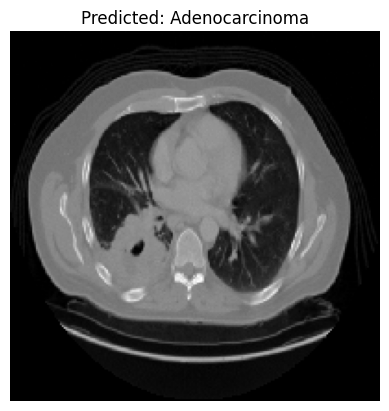

In [18]:
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
import tensorflow as tf

# Function to recreate the DenseNet model for grayscale images
def create_densenet_model():
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
    model = models.Sequential([
        layers.Input(shape=(200, 200, 1)),  # Accept single-channel input
        layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x), output_shape=(200, 200, 3)),  # Convert to RGB
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(4, activation='softmax')  # Assuming 4 classes
    ])
    return model

# Rebuild the model architecture
model = create_densenet_model()

# Load the saved weights into the model
model.load_weights('/content/best_densenet_model.keras')

# Inspect the model structure to check the input layers
model.summary()

# Load the new image as grayscale, then convert it to RGB within the model
img_path = '/content/dataset_lung_health_images/Data/test/adenocarcinoma/000109 (4).png'  # Replace with your image path
img = image.load_img(img_path, target_size=(200, 200), color_mode='grayscale')  # Load image as grayscale

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image data

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Mapping of predicted class index to actual class names
class_names = ['Adenocarcinoma', 'Large cell carcinoma', 'Squamous cell carcinoma', 'Normal']

# Display the result
print(f"Predicted class: {class_names[predicted_class[0]]}")

# Optional: Display the image for confirmation
# Convert img to a NumPy array before using squeeze()
img_array_for_display = image.img_to_array(img)  # Convert to NumPy array
plt.imshow(img_array_for_display, cmap='gray')
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Hide axes
plt.show()